#### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import nltk
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from googletrans.client import Translator
from classes.Accuracy import Accuracy
from classes.ModelBuilder import ModelBuilder
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample, shuffle
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, balanced_accuracy_score
from classes.CustomTokenizer import *
pd.set_option('display.max_colwidth', 600)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Get Info from CSV

In [2]:
columns = ['Pregunta', 'Intencion']
df_train = shuffle(pd.read_csv('data/train.csv', usecols=columns, sep='|'))
df_train['Intencion_cat_label'] = df_train['Intencion'].str[4:]
df_train['Intencion_cat_label'] = df_train['Intencion_cat_label'].astype('int32')

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Helper Code

In [3]:
def plot_occurrences(data, title='Dummy Title'):
    plt.figure(figsize=(35,6))
    sns.countplot(x=data['Intencion_cat_label'], data=data, alpha=0.8, order=data['Intencion_cat_label'].value_counts().index)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Intencion', fontsize=2)
    plt.xticks(rotation=90)
    plt.title(title, fontsize=20)
    plt.show()

#### Category Analisis

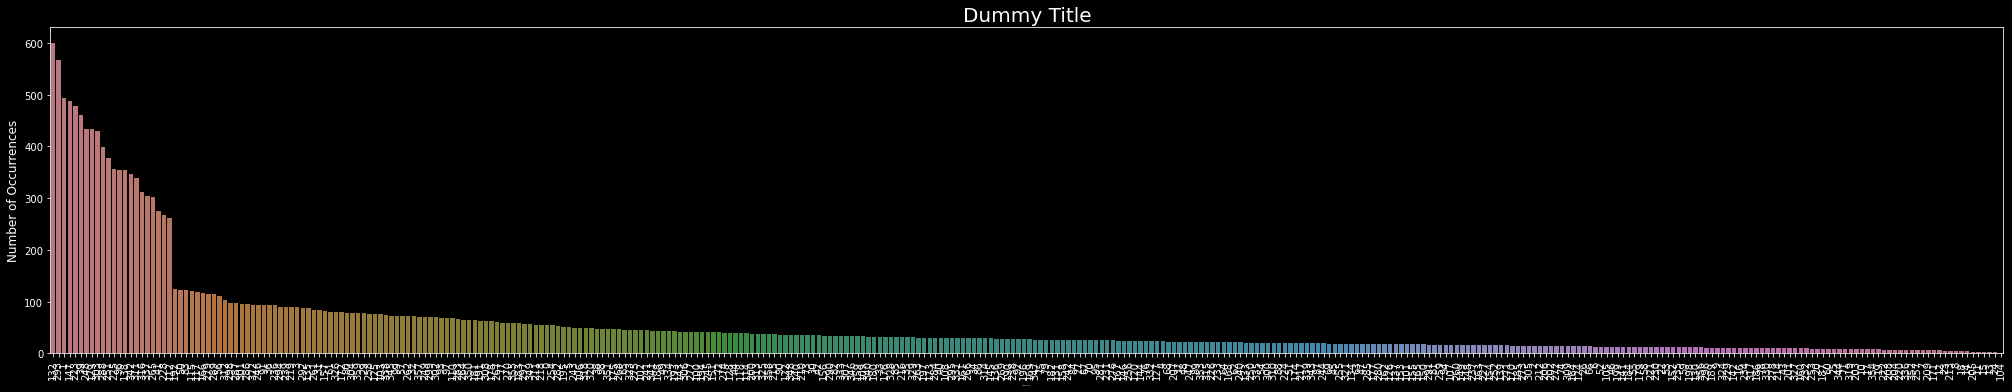

In [4]:
plot_occurrences(df_train)

In [5]:
grouped = df_train.groupby('Intencion_cat_label')['Intencion'].count().sort_values(ascending=True)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
major_samples_ids = grouped[(grouped.values < grouped.max()) & (grouped.values > 50)].index.sort_values(ascending=True)
mid_samples_ids = grouped[(grouped.values <= 50) & (grouped.values > 20)].index.sort_values(ascending=True)
low_samples_ids = grouped[(grouped.values <= 20) & (grouped.values > 0)].index.sort_values(ascending=True)

print('Size each group: Major:{}, Mid:{}, Low:{}'.format(len(major_samples_ids), len(mid_samples_ids), len(low_samples_ids)))

Size each group: Major:93, Mid:127, Low:131


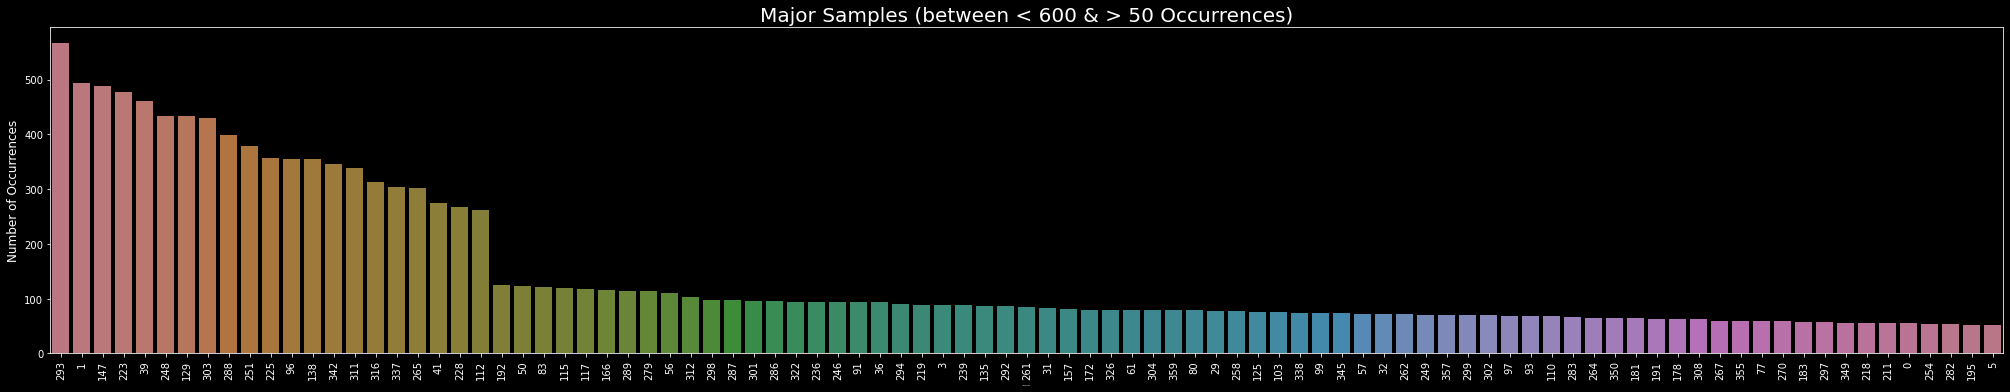

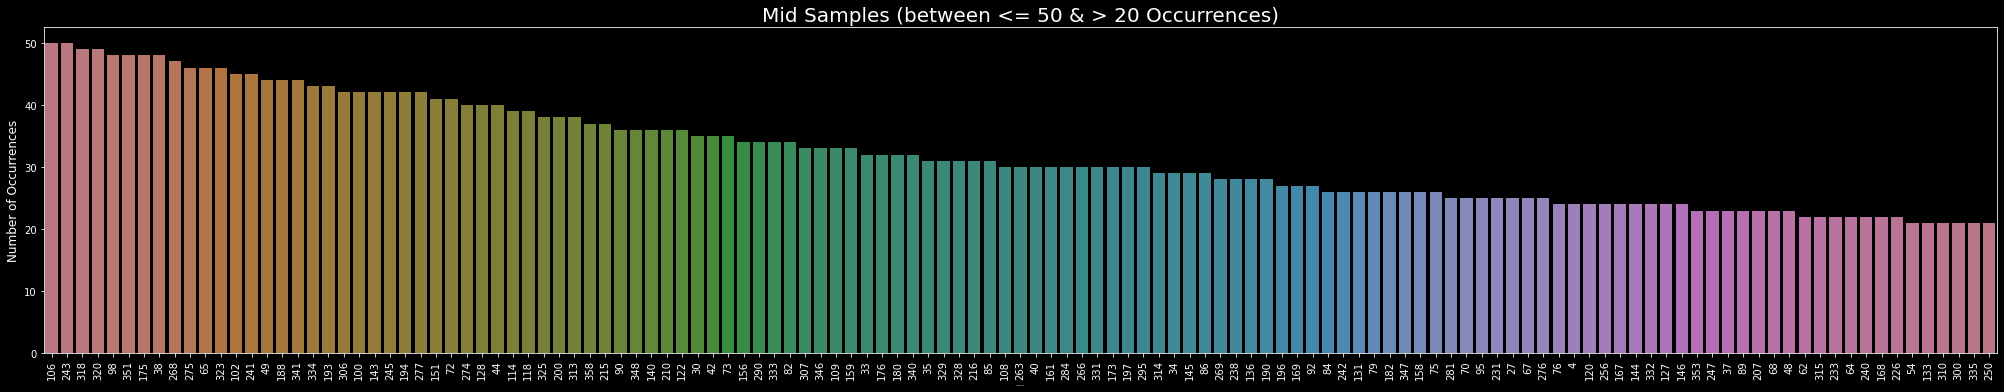

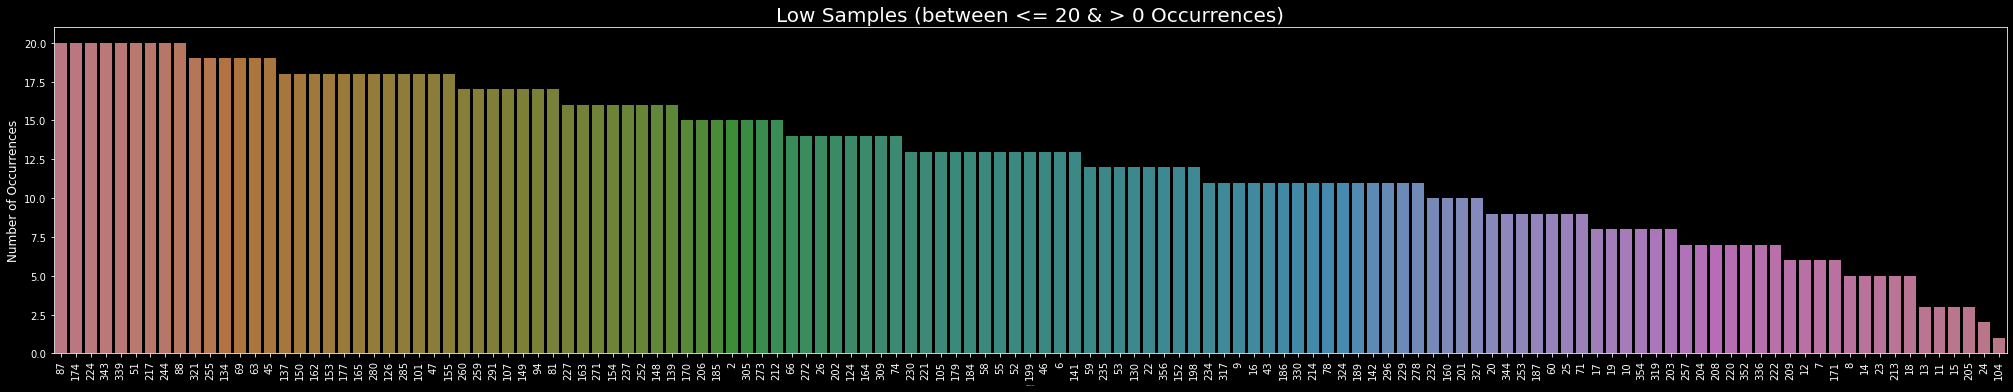

In [7]:
major_samples = df_train[df_train['Intencion_cat_label'].isin(major_samples_ids)]
plot_occurrences(major_samples, 'Major Samples (between < {} & > {} Occurrences)'.format(grouped.max(), 50))
mid_samples = df_train[df_train['Intencion_cat_label'].isin(mid_samples_ids)]
plot_occurrences(mid_samples, 'Mid Samples (between <= 50 & > 20 Occurrences)')
low_samples = df_train[df_train['Intencion_cat_label'].isin(low_samples_ids)]
plot_occurrences(low_samples, 'Low Samples (between <= 20 & > 0 Occurrences)')

#### Translations

In [8]:
df_train['Preguntas_custom_preprocess_no_stopwords'] = [custom_preprocess(sentence, conjugate_verbs=False, removeStopWords=False) for sentence in tqdm.tqdm(df_train['Pregunta'])]
df_train['Preguntas_custom_preprocess'] = [custom_preprocess(sentence, conjugate_verbs=False) for sentence in tqdm.tqdm(df_train['Pregunta'])]
df_train['Preguntas_custom_preprocess_w_verbs'] = [custom_preprocess(sentence, conjugate_verbs=True) for sentence in tqdm.tqdm(df_train['Pregunta'])]
df_train['Preguntas_word_tokenize'] = [nltk.word_tokenize(sentence) for sentence in tqdm.tqdm(df_train['Pregunta'])]
#df_train['Preguntas_preprocessed'] = [nltk.sent_tokenize(sentence) for sentence in tqdm.tqdm(df_train['Pregunta'])]

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20104/20104 [00:02<00:00, 9330.44it/s]


In [19]:
poor_values = df_train[df_train.Intencion_cat_label == 132]
poor_values.sample(3)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pregunta,Intencion,Intencion_cat_label,Preguntas_custom_preprocess_no_stopwords,Preguntas_custom_preprocess,Preguntas_custom_preprocess_w_verbs,Preguntas_word_tokenize
15087,necesitar pagar factura gas,Cat_132,132,"[necesit, pag, factur, gas]","[necesit, pag, factur, gas]","[necesit, pag, factur, gas]","[necesitar, pagar, factura, gas]"
2184,adicionar pagar afip,Cat_132,132,"[adicion, pag, afip]","[adicion, pag, afip]","[adicion, pag, afip]","[adicionar, pagar, afip]"
8609,pagos electronicos,Cat_132,132,"[pag, electron]","[pag, electron]","[pag, electron]","[pagos, electronicos]"


C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 399.5, 199.5, -0.5)

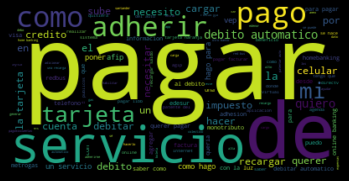

In [18]:
from wordcloud import WordCloud
preguntas = [listToString(sentence) for sentence in poor_values.Preguntas_word_tokenize]
text = " ".join(review for review in pd.unique(preguntas))
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [13]:
mode='w'
header=True
df_train.to_csv('data/train_preprocessed.csv',mode=mode, header=header, index=False, sep='|')

In [11]:
# translations_fr = []
# for sentence in tqdm.tqdm(df_train['Pregunta'].values[:5]):
#     translator = Translator()
#     translation = translator.translate(sentence)
#     translations_fr.append(translation.text)
# print(f'Amount sentences en: {len(translations_fr)}')
# df["Pregunta_fr"] = translations_fr

In [12]:
# translations_es_back = []
# for sent in tqdm(translations_fr):
#     translation = translator.translate(sent, src="fr", dest="es").text
#     translations_es_back.append(translation)
# print(f'Amount sentences en: {len(translations_es_back)}')
# translations_es_back[:2]
# 
# df["Pregunta_es"] = translations_es_back

In [14]:
#tokenizer = CustomTokenizer()
#words = [tokenizer.processAll(sentence, stem=False) for sentence in df_train['Pregunta']]
#
#freq_dist = nltk.FreqDist(np.concatenate(words, axis=0))
#freq_df = pd.DataFrame(list(freq_dist.items()), columns = ["Word","Frequency"])
#
#print('Coincidences for 1: {}'.format(len(freq_df[freq_df['Frequency'] == 1])))
#print('Coincidences for 2: {}'.format(len(freq_df[freq_df['Frequency'] == 2])))
#print('Coincidences for 3: {}'.format(len(freq_df[freq_df['Frequency'] == 3])))
#print('Coincidences for more than 3: {}'.format(len(freq_df[freq_df['Frequency'] > 3])))
#print('FreqDist')
#print(freq_df.sort_values(by='Frequency', ascending=True))